# Notebook for Beaver River diabase and anorthosite xenoliths U-Pb geochronology analyses

In [1]:
import matplotlib
import numpy as np
import pandas as pd

import pmagpy.pmag as pmag
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format='retina'

# Beaver Bay Complex geochronology

New U-Pb dates developed from Beaver Bay Complex intrusive rocks can be compared to U-Pb dates developed from Midcontinent Rift volcanics and published in:

Swanson-Hysell, N.L., Ramenzani, J., Fairchild, L.M. and Rose, I., 2019, **Failed rifting and fast drifting: Midcontinent Rift development, Laurentia's rapid motion and the driver of Grenvillian orogenesis**, *Geological Society of America Bulletin*, doi:10.1130/B31944.1.

Swanson-Hysell, N. L., Hoaglund, S. A., Crowley, J. L., Schmitz, M. D., Zhang, Y., & Miller Jr, J. D. (2021). **Rapid emplacement of massive Duluth Complex intrusions within the Midcontinent Rift**

## Define function to generate date bar plot

In [2]:
def plot_dates(zircon_means, zircon_2sigmas, include, 
               sample_means, sample_2sigmas, colors, labels,
               legend=True, figsize=None, ylim=None, lineweight=None, 
               bbox_to_anchor=None, plot_zircons=True):
    """
    Make a date distribution plot.
    
    inputs:
    - zircon_means = list of numpy arrays containing mean dates (each array being a sample)
    - zircon_2sigmas = list of numpy arrays containing 2sigmas (each array being a sample)
    - include = list of 'yes' or 'no' array for inclusion in mean (each array being a sample)
    - sample_means = list of sample mean dates (one per sample)
    - sample_2sigmas = list of sample 2sigmas (one per sample)
    - colors = list of colors (one per sample)
    - labels = list of labels (one per sample)
    - figsize = figure size (optional)
    - ylim = ylim (optional)
    - linewidth = zircon linewidth (optional)
    - bbox_to_anchor = for the legend (optional)
    """
    # formatting constants
    zircon_spacing = 0.9
    sample_spacing = 5.75 - zircon_spacing
    start_x = 3
    yes_alpha = 0.8
    no_alpha = 0.2
    x_positions = []
    if lineweight==None:
        lineweight=3
    
    # initialize current x
    current_x = start_x
    
    # number of samples
    n_samples = len(zircon_means)
    
    # plot
    if figsize == None:
        fig, ax = plt.subplots()
    else:
        fig, ax = plt.subplots(figsize=figsize)
    
    if plot_zircons == False:
        for i in range(n_samples):
            sample_width = 20

            rectangle = matplotlib.patches.Rectangle((current_x-1, sample_means[i]-sample_2sigmas[i]),\
                                                     sample_width+1, sample_2sigmas[i]*2, color='lightgrey')
            ax.add_patch(rectangle)

            # the mean age

            ax.hlines(sample_means[i], current_x-1, current_x+sample_width)
            
            current_x = current_x + 25
        
    if plot_zircons == True:
        # iterate over each sample
        for i in range(n_samples):

            # number of zircons in sample
            n_zircons = len(zircon_means[i])

            # sample width
            sample_width = zircon_spacing*n_zircons

            rectangle = matplotlib.patches.Rectangle((current_x-1, sample_means[i]-sample_2sigmas[i]),\
                                                     sample_width+1, sample_2sigmas[i]*2, color='lightgrey')
            ax.add_patch(rectangle)

            # the mean age

            ax.hlines(sample_means[i], current_x-1, current_x+sample_width)

            # legend control
            marked = False

            # iterate over each zircon
            for j in range(n_zircons):

                if marked:
                    if include[i][j] == 'yes':
                        ax.vlines(current_x, zircon_means[i][j]-zircon_2sigmas[i][j], zircon_means[i][j]+zircon_2sigmas[i][j],\
                                  colors=colors[i], lw=lineweight, alpha=yes_alpha)
                    else:
                        ax.vlines(current_x, zircon_means[i][j]-zircon_2sigmas[i][j], zircon_means[i][j]+zircon_2sigmas[i][j],\
                                  colors=colors[i], lw=lineweight, alpha=no_alpha)
                else:
                    if include[i][j] == 'yes':
                        ax.vlines(current_x, zircon_means[i][j]-zircon_2sigmas[i][j], zircon_means[i][j]+zircon_2sigmas[i][j],\
                                  colors=colors[i], lw=lineweight, alpha=yes_alpha, label=labels[i])
                        marked = True
                    else:
                        ax.vlines(current_x, zircon_means[i][j]-zircon_2sigmas[i][j], zircon_means[i][j]+zircon_2sigmas[i][j],\
                                  colors=colors[i], lw=lineweight, alpha=no_alpha)

                # tick the x to the next zircon
                current_x = current_x + zircon_spacing

            # tick the x to the next sample
            current_x = current_x + sample_spacing
            x_positions.append(current_x-sample_spacing)
    
    # prettify
    ax.invert_yaxis()
    ax.set_ylabel('$^{206}$Pb/$^{238}$U date (Ma)',fontsize=13)
    if legend == True:
        if bbox_to_anchor == None:
            ax.legend(bbox_to_anchor=(1.8,1), fontsize=12)
        else:
            ax.legend(bbox_to_anchor=bbox_to_anchor, fontsize=12)
    if ylim != None:
        ax.set_ylim(ylim)
        
    return fig, ax, x_positions

In [3]:
def weighted_mean(dates,sigma):
    
    """
    calculated a weighted mean from dates and uncertainities
    
    input parameters
    ----------------
    dates: date of individual grains
    sigma: 1σ uncertainty associated with dates
    
    returns
    ----------------
    weighted_mean, 1σ uncertainty
    
    """
    
    inverse_variance=[]
    alpha=[]
    weighted_mean_calc=[]
    
    for n in range(0,len(dates)):
        value = 1/sigma[n]**2
        inverse_variance.append(value)
    inverse_variance_sum = np.sum(inverse_variance)
    
    for n in range(0,len(dates)):
        value = (1/sigma[n]**2)/inverse_variance_sum
        alpha.append(value)
        
    #calculate the weights for each date    
    for n in range(0,len(dates)):
        value = alpha[n]*dates[n]
        weighted_mean_calc.append(value)
    
    #take the sum of the weights multiplied by the dates to get the weighted
    #mean (equation 64 of McLean et al., 2011)
    weighted_mean = np.sum(weighted_mean_calc)
    
    #the variance of the weighted mean is simply the inverse of the sum of
    #the inverse variances of each date (equation 66 of McLean et al., 2011)
    variance = 1/inverse_variance_sum
    
    weighted_mean_sigma = np.sqrt(variance)
    
    n = len(dates)
    
    print('The weighted mean is:')

    print(weighted_mean)

    print('With a 2sigma error of:')

    print(weighted_mean_sigma)
    
    print('N=' )
    print(n)
    
    return weighted_mean, 2*weighted_mean_sigma

## Import individual zircon dates for the date bar plot

In [4]:
HCT = pd.read_excel('../data/Geochron_published//CAIDTIMS_DataTable_032420.xls',
                      header=49,nrows=11,names=['zircon','Th_U','206Pb_mol','206Pb_mol%','Pb*/Pbc',
                                              'Pbc','206Pb/204Pb','','','','','','','','','','',
                                              '207Pb/206Pb_date','207Pb/206Pb_date_2sigma',
                                              '207Pb/235U_date','207Pb/235U_date_2sigma',
                                              '206Pb/238U_date','206Pb/238U_date_2sigma'])
HCT['include'] = pd.Series(data=['yes','yes','yes','yes','no','no','no','no','no','no','no'])

In [5]:
WLFG = pd.read_excel('../data/Geochron_published/CAIDTIMS_DataTable_032420.xls',
                      header=62,nrows=8,names=['zircon','Th_U','206Pb_mol','206Pb_mol%','Pb*/Pbc',
                                              'Pbc','206Pb/204Pb','','','','','','','','','','',
                                              '207Pb/206Pb_date','207Pb/206Pb_date_2sigma',
                                              '207Pb/235U_date','207Pb/235U_date_2sigma',
                                              '206Pb/238U_date','206Pb/238U_date_2sigma'])
WLFG['include'] = pd.Series(data=['yes','yes','yes','yes','yes','no','no','no'])

In [6]:
NSVG_PR = pd.read_csv('../Data/Geochron_published/NSVG-PR_dates.csv')
NSVG_PR.sort_values('206Pb/238U', inplace=True, ascending=False)
NSVG_PR.reset_index(inplace=True)

PLV_GS1 = pd.read_csv('../Data/Geochron_published/PLV-GS1_dates.csv')
PLV_GS1.sort_values('206Pb/238U', inplace=True, ascending=False)
PLV_GS1.reset_index(inplace=True)

BBC_SBA1 = pd.read_csv('../Data/Geochron_published/BBC-SBA1_dates.csv')
BBC_SBA1.sort_values('206Pb/238U', inplace=True, ascending=False)
BBC_SBA1.reset_index(inplace=True)

In [7]:
MS99033 = pd.read_csv('../data/Geochron_new/MS99033.csv')
MS99033.sort_values('206Pb/238U', inplace=True, ascending=False)
MS99033.reset_index(inplace=True)

## check MS99033 weighted mean calculation

In [8]:
weighted_mean(MS99033['206Pb/238U'].tolist()[:6], MS99033['206Pb/238U_2sigma'].tolist()[:6])

The weighted mean is:
1091.8253210673477
With a 2sigma error of:
0.21159466422228637
N=
6


(1091.8253210673477, 0.42318932844457274)

In [9]:
BBC_U_Pb_zircon_dates = [
    NSVG_PR['206Pb/238U'].tolist(),
    WLFG['206Pb/238U_date'].tolist(),
                         MS99033['206Pb/238U'].tolist(),
                         BBC_SBA1['206Pb/238U'].tolist(),
                         PLV_GS1['206Pb/238U'].tolist()
                        ]

BBC_U_Pb_zircon_2sigmas = [
    NSVG_PR['206Pb/238U_2sigma'].tolist(), 
    WLFG['206Pb/238U_date_2sigma'].tolist(),
                           MS99033['206Pb/238U_2sigma'].tolist(),
                           BBC_SBA1['206Pb/238U_2sigma'].tolist(), 
                           PLV_GS1['206Pb/238U_2sigma'].tolist()
]

BBC_U_Pb_zircon_include = [
    NSVG_PR['include'].tolist(),
    WLFG['include'].tolist(),
    MS99033['include'].tolist(), 
    BBC_SBA1['include'].tolist(),
    PLV_GS1['include'].tolist()
]

NSVG_PR_mean = 1093.94
MS99033_mean = 1091.83
BBC_SBA1_mean = 1091.61
WLFG_mean = 1091.63
PLV_GS1_mean = 1091.59

BBC_U_Pb_sample_means = [
    NSVG_PR_mean, WLFG_mean,
                         MS99033_mean, 
                         BBC_SBA1_mean, 
                         PLV_GS1_mean
                        ]

NSVG_PR_2sigma = 0.28
MS99033_2sigma = 0.21
BBC_SBA1_2sigma = 0.14
WLFG_2sigma = 0.35
PLV_GS1_2sigma = 0.27

BBC_U_Pb_sample_2sigmas = [
    NSVG_PR_2sigma, 
    WLFG_2sigma, 
                           MS99033_2sigma,
                           BBC_SBA1_2sigma, 
                           PLV_GS1_2sigma
]

BBC_colors = [
    'green',
    'mediumaquamarine',
              'darkorange',
              'deeppink', 
              'purple'
]

BBC_labels = [
    'Palisade Rhyolite',
    'Wilson Lake ferrogabbro',
              'Beaver River anorthosite',
              'Silver Bay Aplite', 
              'Greenstone Flow'
]

In [10]:
BBC_geochron = pd.DataFrame({'labels': BBC_labels, 
                      'polarity_colors' : BBC_colors, 
                      'U_Pb_zircon_dates': BBC_U_Pb_zircon_dates, 
                      'U_Pb_zircon_2sigmas': BBC_U_Pb_zircon_2sigmas,
                      'U_Pb_zircon_include': BBC_U_Pb_zircon_include,
                      'U_Pb_sample_mean': BBC_U_Pb_sample_means,
                      'U_Pb_sample_2sigma': BBC_U_Pb_sample_2sigmas})

# BBC_geochron.to_csv('../data/compiled_BBC_geochron.csv')
# geochron_data = pd.read_csv('../data/compiled_BBC_geochron.csv')
BBC_geochron

,labels,polarity_colors,U_Pb_zircon_dates,U_Pb_zircon_2sigmas,U_Pb_zircon_include,U_Pb_sample_mean,U_Pb_sample_2sigma
0,Palisade Rhyolite,green,"[1096.29, 1094.66, 1094.47, 1094.34, 1094.19, ...","[1.53, 0.69, 0.77, 0.7, 1.14, 1.09, 0.87, 0.49]","[no, yes, yes, yes, yes, yes, yes, yes]",1093.94,0.28
1,Wilson Lake ferrogabbro,mediumaquamarine,"[1091.851708622979, 1091.8099974724937, 1091.6...","[0.4925351441420653, 1.3504666868452266, 1.145...","[yes, yes, yes, yes, yes, no, no, no]",1091.63,0.35
2,Beaver River anorthosite,darkorange,"[1091.971169, 1091.963826, 1091.940206, 1091.8...","[0.774118697, 0.45739525, 0.459814406, 0.55184...","[yes, yes, yes, yes, yes, yes, no, no]",1091.83,0.21
3,Silver Bay Aplite,deeppink,"[1091.766875, 1091.6649869999999, 1091.482674,...","[0.318121361, 0.298447953, 0.354731588, 0.3789...","[yes, yes, yes, yes, yes, yes]",1091.61,0.14
4,Greenstone Flow,purple,"[1092.64, 1091.71, 1091.65, 1091.62, 1091.32, ...","[0.94, 0.52, 0.75, 0.95, 0.67, 0.49]","[yes, yes, yes, yes, yes, yes]",1091.59,0.27


## Generate geochron figure

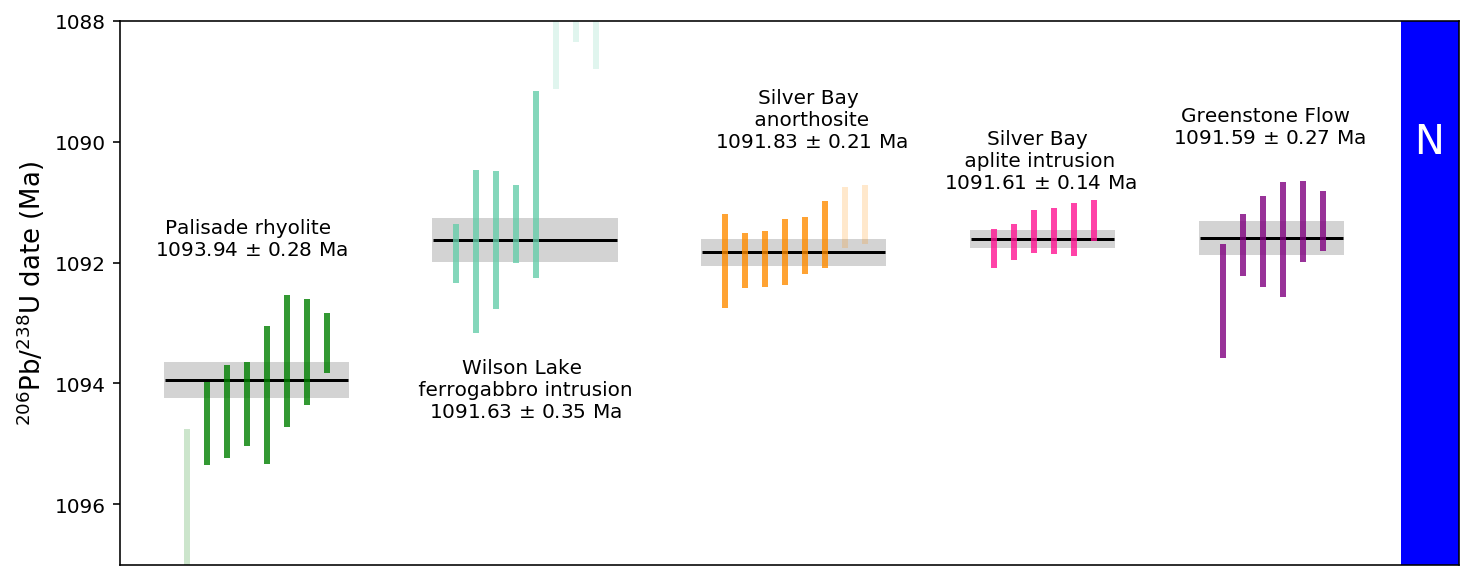

In [11]:
fig, ax, x_positions = plot_dates(BBC_geochron.U_Pb_zircon_dates, BBC_geochron.U_Pb_zircon_2sigmas, 
                                  BBC_geochron.U_Pb_zircon_include, 
                                  BBC_geochron.U_Pb_sample_mean, BBC_geochron.U_Pb_sample_2sigma, 
                                  BBC_colors, BBC_labels, legend=False, figsize=(12,5))

max_x_value = 60
ax.set_ylim(1097,1088)
ax.set_xlim(0,max_x_value)
ax.set_xticks([])
ax.set_yticks([1088, 1090, 1092, 1094, 1096])

ax.text(x_positions[0],BBC_U_Pb_sample_means[0]-2,'Palisade rhyolite \n1093.94 $\pm$ 0.28 Ma',size='10',horizontalalignment='right',
        verticalalignment='bottom',multialignment='center')
ax.text(x_positions[1]+1.,BBC_U_Pb_sample_means[1]+3., 'Wilson Lake \n ferrogabbro intrusion \n1091.63 $\pm$ 0.35 Ma',size='10',horizontalalignment='right',
        verticalalignment='bottom',multialignment='center')
ax.text(x_positions[2]+1.,BBC_U_Pb_sample_means[3]-1.45,'Silver Bay \n anorthosite \n1091.83 $\pm$ 0.21 Ma',size='10',horizontalalignment='right',
        verticalalignment='bottom',multialignment='center')
ax.text(x_positions[3]+1.,BBC_U_Pb_sample_means[2]-1.,'Silver Bay \n aplite intrusion \n1091.61 $\pm$ 0.14 Ma',size='10',horizontalalignment='right',
        verticalalignment='bottom',multialignment='center')
ax.text(x_positions[4]+1.,BBC_U_Pb_sample_means[4]-1.5,'Greenstone Flow \n1091.59 $\pm$ 0.27 Ma',size='10',horizontalalignment='right',
        verticalalignment='bottom',multialignment='center')

Portage_Lake_N = matplotlib.patches.Rectangle((max_x_value-2.55, 1070), 2.5, 29.9, color='blue')
ax.add_patch(Portage_Lake_N)
ax.text(max_x_value-2, 1090,'N',size='20',color='white',verticalalignment='center')
# ax.text(158.5, 1094,'Portage Lake\nNormal\nPolarity Zone',size='11',horizontalalignment='right')

# plt.savefig('code_output/geochron/BBC_dates.pdf',bbox_inches='tight')
plt.show(fig)

## Monte Carlo simulation for diabase emplacement age

In [12]:
n_MC = 100000
diabase_ages = []

for n in range(0,n_MC):
    max_age = np.random.normal(MS99033_mean,MS99033_2sigma/2)
    min_age = np.random.normal(BBC_SBA1_mean,BBC_SBA1_2sigma/2)
    diabase_age = np.random.uniform(min_age,max_age)
    diabase_ages.append(diabase_age)

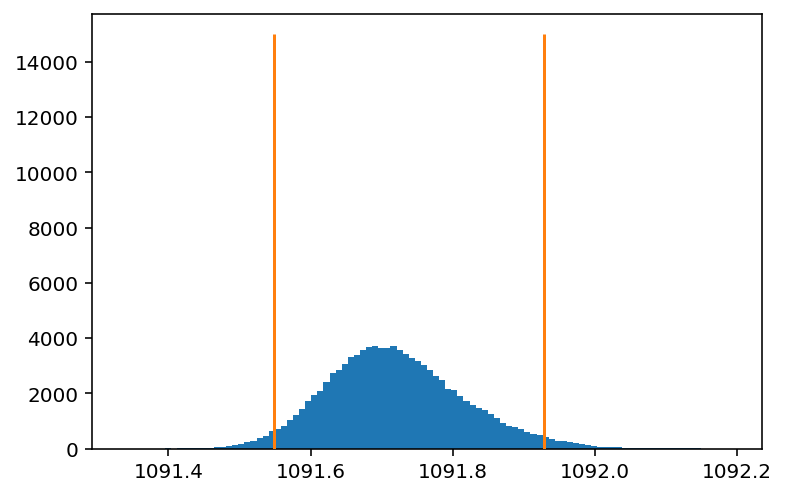

In [13]:
diabase_age_upper = np.percentile(diabase_ages,97.5)
diabase_age_mid = np.percentile(diabase_ages,50)
diabase_age_lower = np.percentile(diabase_ages,2.5)

plt.hist(diabase_ages,bins=100)
plt.vlines(diabase_age_lower,0,15000,color='C1',zorder=1000)
plt.vlines(diabase_age_upper,0,15000,color='C1',zorder=1000)
plt.show()

In [14]:
round(diabase_age_lower,1), round(diabase_age_upper,1)

(1091.5, 1091.9)

## Evaluting the possibility of diffusive loss

Shown below are conditions for diffusional Pb loss in crystalline zircon for zircons of effective radii of 100 µm. Curves represent time–temperature conditions under which zircon will lose the indicated fraction of total Pb.


- Cherniak, D. J., & Watson, E. B. (2001). Pb diffusion in zircon. Chemical Geology, 172(1-2), 5-24.

In [123]:
def get_temp_from_yr(diff_length, yrs):
    return -545000/np.log((diff_length/1000000)**2/0.0776/Julian_year/yrs)/R - 273.15


In [124]:
# to get % loss we need:
def temp_yr_given_perc(percent_loss = 0.9, eff_radii=100, yrs = np.logspace(0, 9, 50)):
    eff_radii = eff_radii
    perc_loss = percent_loss
    zircon_vol = 4/3*np.pi*eff_radii**3
    left_vol = zircon_vol*(1-perc_loss)*3/4/np.pi
    left_radii = np.cbrt(left_vol)

    diff_length = eff_radii-left_radii

    yrs = yrs

    temps = get_temp_from_yr(diff_length, yrs)
    return temps

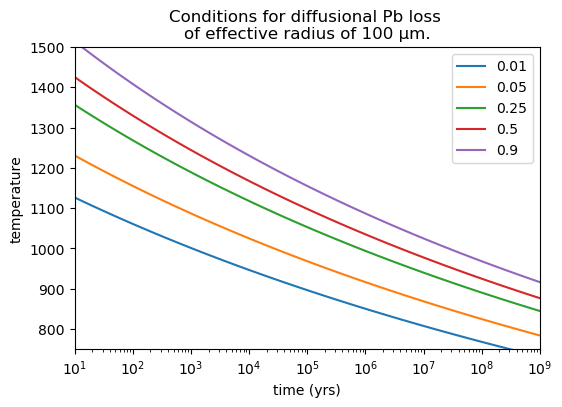

In [126]:
perc = [0.01, 0.05, 0.25, 0.5, 0.9]
yrs = np.logspace(0, 9, 50)
temps = []
for i in perc:
    temps.append(temp_yr_given_perc(percent_loss = i, eff_radii=100, yrs = np.logspace(0, 9, 50)))
for i in range(len(temps)):
    plt.plot(yrs, temps[i], label=str(perc[i]))
plt.xlim(10, 1e9)
plt.ylim(750, 1500)
plt.xticks([1e2, 1e3, 1e4, 1e5, 1e6, 1e7, 1e8, 1e9])
plt.xscale('log')
plt.legend()
plt.title('Conditions for diffusional Pb loss \nof effective radius of 100 µm.')
plt.xlabel('time (yrs)')
plt.ylabel('temperature')
plt.show()

In [15]:
lambda_238 = 1.55125e-10
U_238 = 10000
t_reset = 4.4e6
t_post_reset = 1091.6e6

diffuse_frac_list = np.linspace(0.90,0.99,6)
DC_date_list = []

for diffuse_frac in diffuse_frac_list:

    Pb_206_prereset = (np.exp(lambda_238*t_reset)-1)*U_238
    Pb_206_reset = Pb_206_prereset - (Pb_206_prereset*diffuse_frac)
    Pb_206_postreset = ((np.exp(lambda_238*t_post_reset)-1)*U_238)
    date = np.log(((Pb_206_postreset+Pb_206_reset)/U_238)+1)/lambda_238
    DC_date_list.append(date)
    
lambda_238 = 1.55125e-10
U_238 = 10000
t_reset = 708e6
t_post_reset = 1091.6e6

Paleoprot_date_list = []

for diffuse_frac in diffuse_frac_list:

    Pb_206_prereset = (np.exp(lambda_238*t_reset)-1)*U_238
    Pb_206_reset = Pb_206_prereset - (Pb_206_prereset*diffuse_frac)
    Pb_206_postreset = ((np.exp(lambda_238*t_post_reset)-1)*U_238)
    date = np.log(((Pb_206_postreset+Pb_206_reset)/U_238)+1)/lambda_238
    Paleoprot_date_list.append(date)

In [16]:
diffuse_frac_list

array([0.9  , 0.918, 0.936, 0.954, 0.972, 0.99 ])

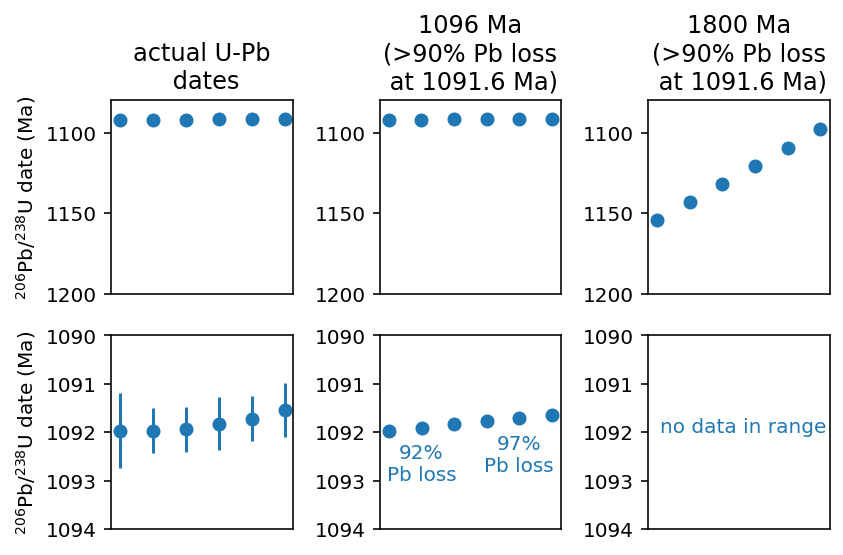

In [17]:
y_min = 1080
y_max = 1200

plt.subplot(2,3,1)
plt.errorbar(np.arange(0,len(MS99033['206Pb/238U'].tolist()[0:6])),
            MS99033['206Pb/238U'].tolist()[0:6], yerr=MS99033['206Pb/238U_2sigma'][0:6],fmt='o')
plt.ylim(y_max,y_min)
plt.gca().set_xticks([])
plt.ylabel('$^{206}$Pb/$^{238}$U date (Ma)')
plt.title('actual U-Pb\n dates')
plt.subplot(2,3,2)
plt.scatter(np.arange(0,len(DC_date_list)),np.array(DC_date_list)/1e6)
plt.ylim(y_max,y_min)
plt.gca().set_xticks([])
plt.title('1096 Ma\n(>90% Pb loss\n at 1091.6 Ma)')
plt.subplot(2,3,3)
plt.scatter(np.arange(0,len(Paleoprot_date_list)),np.array(Paleoprot_date_list)/1e6)
plt.ylim(y_max,y_min)
plt.gca().set_xticks([])
plt.title('1800 Ma\n(>90% Pb loss\n at 1091.6 Ma)')
plt.tight_layout()

y_min = 1090
y_max = 1094

plt.subplot(2,3,4)
plt.errorbar(np.arange(0,len(MS99033['206Pb/238U'].tolist()[0:6])),
            MS99033['206Pb/238U'].tolist()[0:6], yerr=MS99033['206Pb/238U_2sigma'][0:6],fmt='o')
plt.ylim(y_max,y_min)
plt.gca().set_xticks([])
plt.ylabel('$^{206}$Pb/$^{238}$U date (Ma)')
plt.subplot(2,3,5)
plt.scatter(np.arange(0,len(DC_date_list)),np.array(DC_date_list)/1e6)
plt.text(1,1093,'92%\nPb loss',color='C0',horizontalalignment='center')
plt.text(4,1092.8,'97%\nPb loss',color='C0',horizontalalignment='center')
plt.ylim(y_max,y_min)
plt.gca().set_xticks([])
plt.subplot(2,3,6)
plt.scatter(np.arange(0,len(Paleoprot_date_list)),np.array(Paleoprot_date_list)/1e6)
plt.ylim(y_max,y_min)
plt.text(0.1,1092,'no data in range',color='C0')
plt.gca().set_xticks([])
plt.tight_layout()
plt.savefig('./code_output/geochron/diffusive_loss.pdf')

In [18]:
np.mean(DC_date_list)/1e6

1091.8043683018623

In [19]:
np.mean(Paleoprot_date_list)/1e6

1126.2251311192024